# Прогноз с использованием статистик churn rate и income rate

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv #вычисление обратной матрицы
from sklearn.metrics import mean_absolute_error #поиск средней ошибки в абсолютном и квадратичном смысле

data = pd.read_csv("classes.csv")

In [4]:
data['start_at']= pd.to_datetime(data['start_at']) 
#data.sort_values(by = "start_at", inplace = True)
data['year'] = data['start_at'].dt.year
data['month'] = data['start_at'].dt.month
full_data = data.groupby(['year', 'month'])['teacher_id'].nunique()

Анализ данных за прошлые месяца на предмет оттока и приток учителей

In [5]:
teachers_left = list()
teachers_stayed = list()
teachers_new = list()

for i in range(2017,2020):
        for j in range(1,13):
            temp1 = data[(data['year'] == i) & (data['month']==j)].drop_duplicates(subset='teacher_id')
            if j == 12:
                j = 0
                i = i+1
            temp2 = data[(data['year'] == i) & (data['month']==j+1)].drop_duplicates(subset='teacher_id')
            stayed = pd.merge(temp1, temp2, on='teacher_id').count().teacher_id
            left = temp1.count().teacher_id - stayed
            came = temp2.count().teacher_id - stayed
            if temp1.size > 0:
                teachers_left.append(left)
                teachers_stayed.append(stayed)
                teachers_new.append(came)

In [6]:
full_data = pd.DataFrame(full_data)
full_data.columns = ["count_teachers"]

In [7]:
full_data["teachers_stayed"] = full_data["teachers_left"] = full_data["teachers_new"] = 0
full_data["teachers_churn_rate"] = full_data["teachers_income_rate"] = 0
for i in range (1, 25):
    full_data.iloc[i, full_data.columns.get_loc('teachers_stayed')] = teachers_stayed[i-1]
    full_data.iloc[i, full_data.columns.get_loc('teachers_left')] = teachers_left[i-1]
    full_data.iloc[i, full_data.columns.get_loc('teachers_new')] = teachers_new[i-1]
    full_data.iloc[i, full_data.columns.get_loc('teachers_churn_rate')] = teachers_left[i-1]/full_data.iloc[i-1, full_data.columns.get_loc('count_teachers')]
    full_data.iloc[i, full_data.columns.get_loc('teachers_income_rate')] = teachers_new[i-1]/full_data.iloc[i-1, full_data.columns.get_loc('count_teachers')]
    
full_data

count_teachers  teachers_stayed  teachers_left  teachers_new  \
year month                                                                 
2017 9                1207                0              0             0   
     10               1273             1140             67           133   
     11               1463             1202             71           261   
     12               1693             1381             82           312   
2018 1                1806             1570            123           236   
     2                2088             1708             98           380   
     3                2488             1970            118           518   
     4                2854             2333            155           521   
     5                3256             2692            162           564   
     6                3517             3014            242           503   
     7                3739             3188            329           551   
     8                4009             3387            352           622   
     9                4299             3663            346           636   
     10               4631             3995            304           636   
     11               4774             4341            290           433   
     12               4883             4501            273           382   
2019 1                5153             4577            306           576   
     2                5681             4904            249           777   
     3                6197             5388            293           809   
     4                6644             5873            324           771   
     5                7024             6299            345           725   
     6                7154             6553            471           601   
     7                7303             6544            610           759   
     8                7776             6756            547          1020   
     9                8252             7166            610          1086   

            teachers_churn_rate  teachers_income_rate  
year month                                             
2017 9                 0.000000              0.000000  
     10                0.055510              0.110191  
     11                0.055774              0.205027  
     12                0.056049              0.213260  
2018 1                 0.072652              0.139398  
     2                 0.054264              0.210410  
     3                 0.056513              0.248084  
     4                 0.062299              0.209405  
     5                 0.056762              0.197617  
     6                 0.074324              0.154484  
     7                 0.093546              0.156668  
     8                 0.094143              0.166355  
     9                 0.086306              0.158643  
     10                0.070714              0.147941  
     11                0.062621              0.093500  
     12                0.057185              0.080017  
2019 1                 0.062666              0.117960  
     2                 0.048321              0.150786  
     3                 0.051575              0.142405  
     4                 0.052283              0.124415  
     5                 0.051927              0.109121  
     6                 0.067056              0.085564  
     7                 0.085267              0.106094  
     8                 0.074901              0.139669  
     9                 0.078447              0.139660

Оценка числа преподавателей без влияния коэффициентов оттока и притока

In [8]:
Y_true = full_data['count_teachers']
Y_true.index = range(25)

Y = np.matrix(Y_true).T
Y_train = Y[:-1]
A = np.matrix(np.concatenate((np.ones(shape = (Y_true.size-1, 1), dtype = int), np.arange(0,Y_true.size-1).reshape(Y_true.size-1,1)), axis=1))
#один месяц отрезаем для проверки

In [9]:
tetta = np.dot(np.dot(inv(np.dot(A.T,A)),A.T), Y_train)
a0 = float(tetta[0,0])
k = float(tetta[1,0])
print("Оценки параметров: a = {0}, k = {1} ".format(a0, k))

Оценки параметров: a = 810.0966666666673, k = 295.18000000000006 


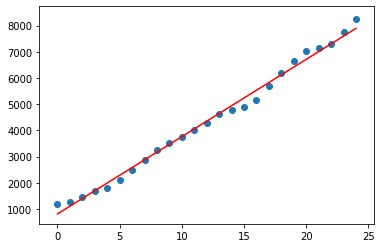

In [10]:
x = np.linspace(0, Y_train.size,Y_train.size + 1)
Y_pred = a0 + x * k

plt.plot(x, Y_pred, '-r')
plt.scatter(Y_true.index, Y_true)
plt.show()

Вычислением средних значений оттока и притока в разные месяца

In [41]:
churn = full_data.loc[2018:2020].groupby(['month'])['teachers_churn_rate', 'teachers_income_rate'].mean()

Прогноз делайется исходя из количества (если неизвестно - оценки количества) преподавателей в прошлом месяце

In [12]:
print("Ошибка в тестовом месяце ", (a0 + (Y_train.size-1) * k + (a0 + (Y_train.size-1) * k)*(churn['teachers_income_rate'][9]-churn['teachers_churn_rate'][9]))-Y_true[Y_train.size])

Ошибка в тестовом месяце  -145.31962007529364


In [13]:
print("Предсказанное количество преподавателей в следующем месяце ", (a0 + Y_train.size * k + (a0 + Y_train.size * k)*(churn['teachers_income_rate'][10]-churn['teachers_churn_rate'][10])))

Предсказанное количество преподавателей в следующем месяце  8504.080852136158


### Оценка точности модели

In [42]:
j = 5
res = 0
for i in range(20,25):
    res = res + abs(Y_true[i] - (Y_pred[i-1] + Y_pred[i-1]*(churn['teachers_income_rate'][j]-churn['teachers_churn_rate'][j])))
    j = j + 1
print("Средняя абсолютная ошибка за последние пять месяцев: ", res/5)

Средняя абсолютная ошибка за последние пять месяцев:  62.58037132182635
